# 1D Convolution Example For Time Series Data 

This example uses the SAS DLPy Python API to demonstrate how to build a simple neural network that uses 1-D convolutions with time series data to classify a subject's activity from a set of six possible activities. 

This example uses the Wireless Sensor Data Mining (WISDM) data. The WISDM data is public and can be downloaded from [WISDM Labs](http://www.cis.fordham.edu/wisdm/dataset.php). The data was collected in controlled laboratory conditions using accelerometer sensors to identify 6 activities in a subject. The activities are walking, jogging, ascending stairs (upstairs), descending stairs (downstairs), sitting, and standing.

This example follows a Keras model created for analytic sequences shown in [Nils Ackerman's blog](https://blog.goodaudience.com/introduction-to-1d-convolutional-neural-networks-in-keras-for-time-sequences-3a7ff801a2cf) and uses the codes from the [Human Activity Recognition (HAR) CNN Network](https://github.com/ni79ls/har-keras-cnn).

This 1-D Convolution example for time series data takes the following steps:

* Import SWAT and Python modules
* Prepare and Transform Data
* Load and Explore the Data
* Split the Training Data
* Build the Model with 1-D Convolutions
* Train the Model with 1-D Convolutions
* Assess the Model Performance Using Test Data


# Import SWAT and Python modules

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn import preprocessing
import matplotlib.pylab as plt
# Import SAS Scripted Wrapper for Analytics Transfer (SWAT) modules.
from swat.cas import datamsghandlers
from swat import CAS, CASTable

# Specify and Load Selected DLPy modules.
from dlpy import Model, Sequential
from dlpy.model import Optimizer, MomentumSolver, AdamSolver, Gpu
from dlpy.layers import * 
from dlpy.splitting import two_way_split
from dlpy.metrics import (accuracy_score, confusion_matrix, plot_roc, 
                          plot_precision_recall, roc_auc_score, f1_score, average_precision_score)
%matplotlib inline

# Prepare and transform the data

In [2]:
# Some of the functions used to read and transform the WISDM 
# data in the following code are copied from https://github.com/ni79ls/har-keras-cnn
#
# If you like using open source APIs to process data, 
# this example shows how you can use the SAS DLPy 
# open-source API to integrate SAS Deep Learning with 
# your open-source code.

def feature_normalize(dataset):

    mu = np.mean(dataset, axis=0)
    sigma = np.std(dataset, axis=0)
    return (dataset - mu)/sigma


def read_data(file_path):

    """
    This function reads the accelerometer data from a file

    Args:
        file_path: URL pointing to the CSV file

    Returns:
        A pandas dataframe
    """

    column_names = ['user-id',
                    'activity',
                    'timestamp',
                    'x-axis',
                    'y-axis',
                    'z-axis']
    df = pd.read_csv(file_path,
                     header=None,
                     names=column_names)
    # Last column has a ";" character which must be removed ...
    df['z-axis'].replace(regex=True,
      inplace=True,
      to_replace=r';',
      value=r'')
    # ... and then this column must be transformed to float explicitly
    df['z-axis'] = df['z-axis'].apply(convert_to_float)
    # This is very important otherwise the model will not fit and loss
    # will show up as NAN
    df.dropna(axis=0, how='any', inplace=True)

    return df


def convert_to_float(x):

    try:
        return np.float(x)
    except:
        return np.nan


# Not used right now
def feature_normalize(dataset):

    mu = np.mean(dataset, axis=0)
    sigma = np.std(dataset, axis=0)
    return (dataset - mu)/sigma


def plot_axis(ax, x, y, title):

    ax.plot(x, y)
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)


def plot_activity(activity, data):

    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3,
         figsize=(15, 10),
         sharex=True)
    plot_axis(ax0, data['timestamp'], data['x-axis'], 'x-axis')
    plot_axis(ax1, data['timestamp'], data['y-axis'], 'y-axis')
    plot_axis(ax2, data['timestamp'], data['z-axis'], 'z-axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()


def create_segments_and_labels(df, time_steps, step, label_name):

    """
    This function receives a dataframe and returns the reshaped segments
    of x,y,z acceleration as well as the corresponding labels

    Args:
        df: Dataframe in the expected format
        time_steps: Integer value of the length of a segment that is created
    Returns:
        reshaped_segments
        labels:
    """

    # x, y, z acceleration as features
    N_FEATURES = 3
    # Number of steps to advance in each iteration (for me, it should always
    # be equal to the time_steps in order to have no overlap between segments)
    # step = time_steps
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs = df['x-axis'].values[i: i + time_steps]
        ys = df['y-axis'].values[i: i + time_steps]
        zs = df['z-axis'].values[i: i + time_steps]
        # Retrieve the most often used label in this segment
        label = stats.mode(df[label_name][i: i + time_steps])[0][0]
        segments.append([xs, ys, zs])
        labels.append(label)

    # Bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels



In [3]:
# The WISDM data has six labels to describe subject activity classes:

LABELS = ["Downstairs",
          "Jogging",
          "Sitting",
          "Standing",
          "Upstairs",
          "Walking"]


# Load data set containing all the data from csv
df = read_data('WISDM_ar_v1.1_raw.txt')

In [4]:
# Convert the labels into integer mapping
# Define column name of the label vector
LABEL = "ActivityEncoded"
# Transform the labels from String to Integer via LabelEncoder
le = preprocessing.LabelEncoder()
# Add a new column to the existing DataFrame with the encoded values
df[LABEL] = le.fit_transform(df["activity"].values.ravel())

In [5]:
df.head(5)

,user-id,activity,timestamp,x-axis,y-axis,z-axis,ActivityEncoded
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953,1
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424,1
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722,1
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717,1
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164,1


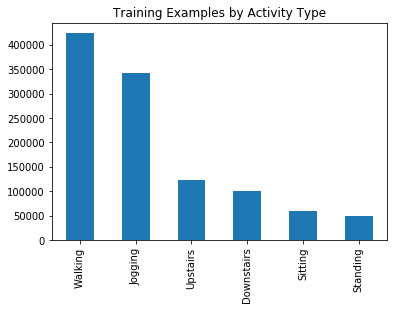

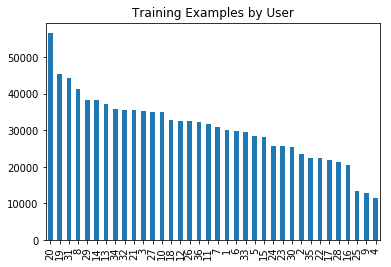

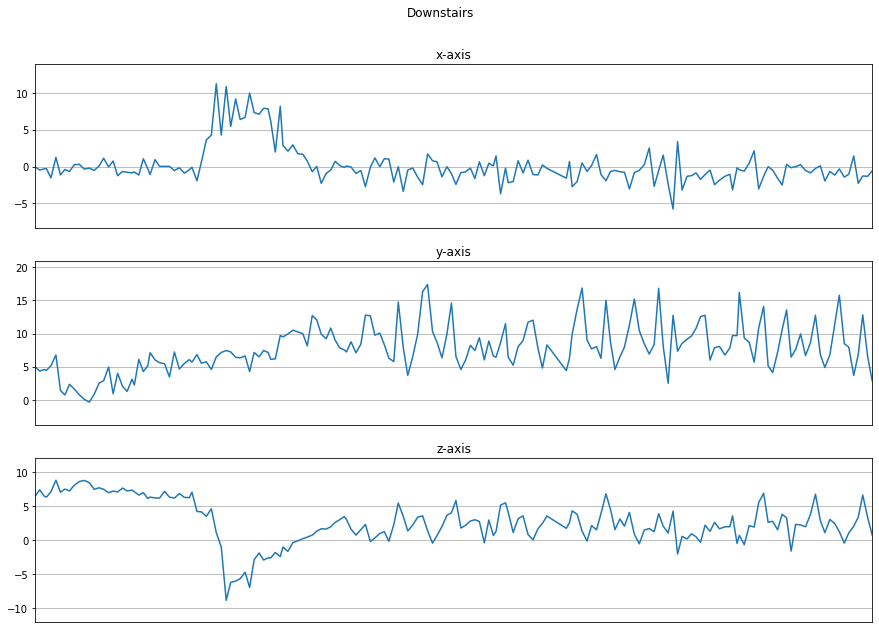

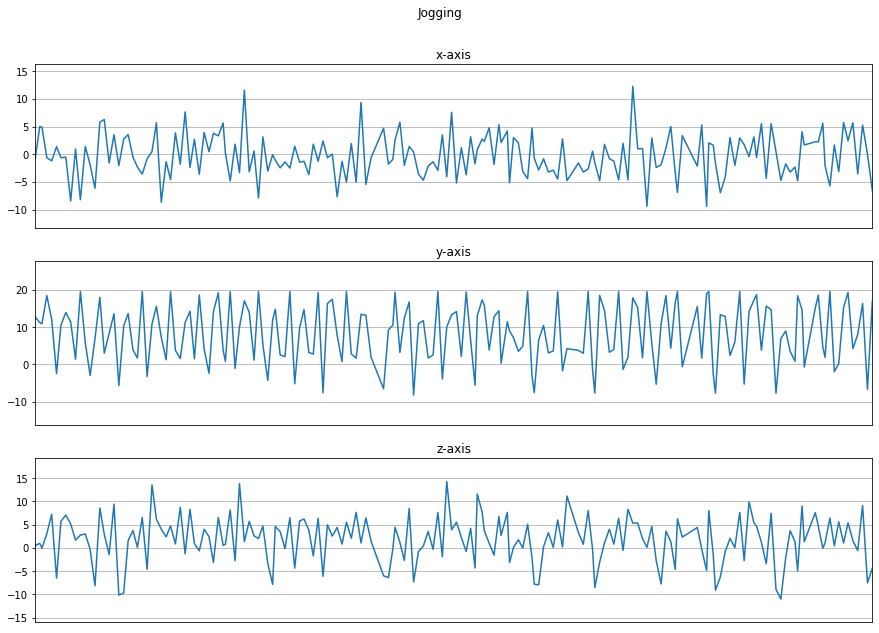

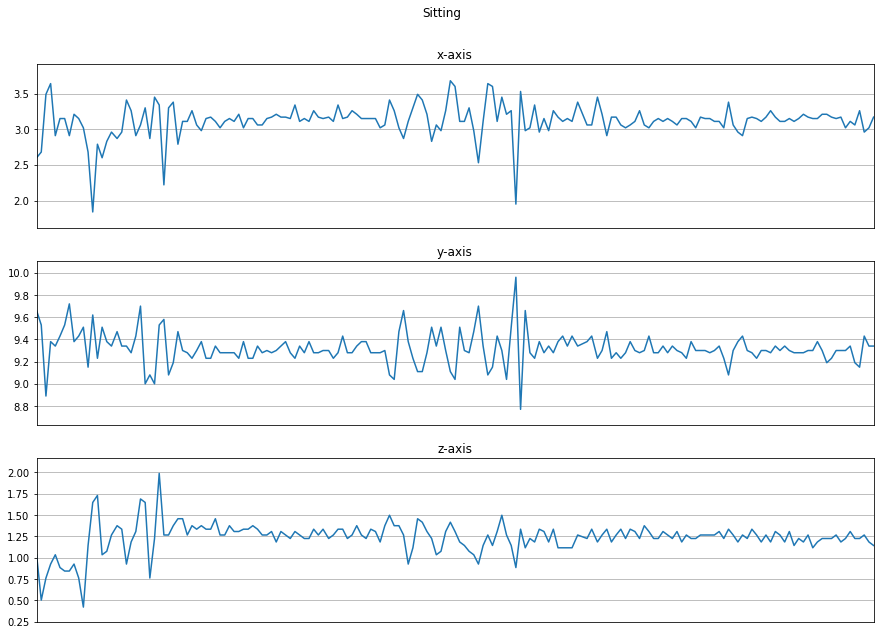

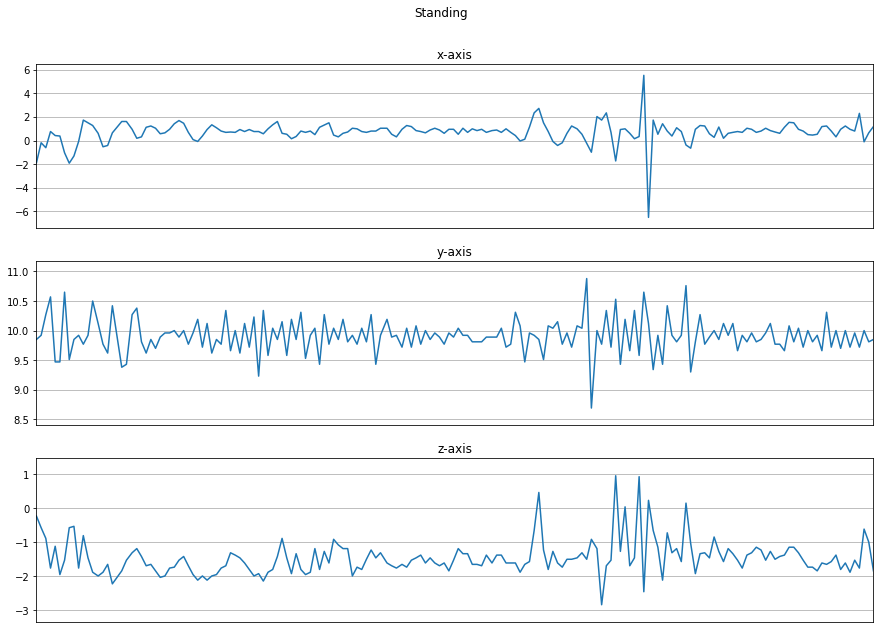

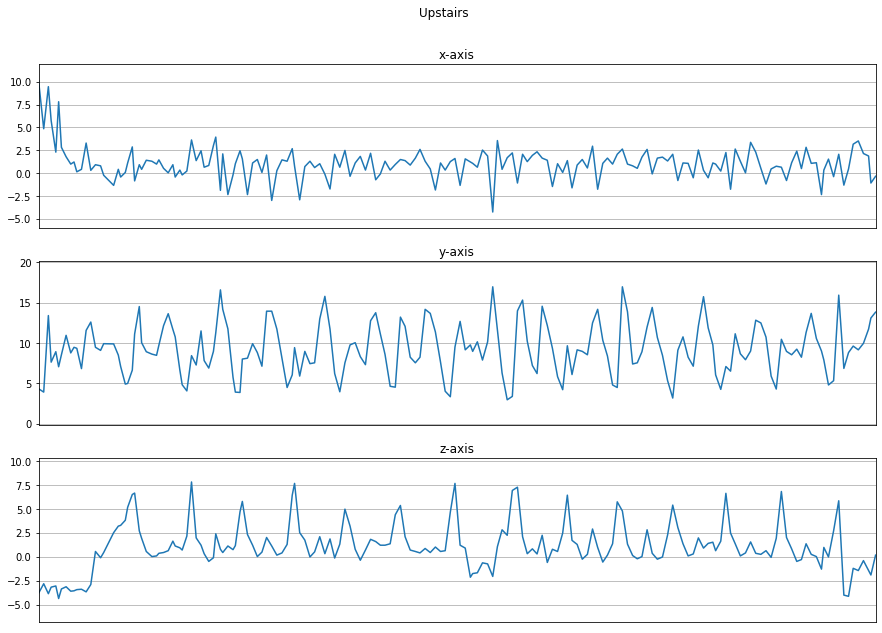

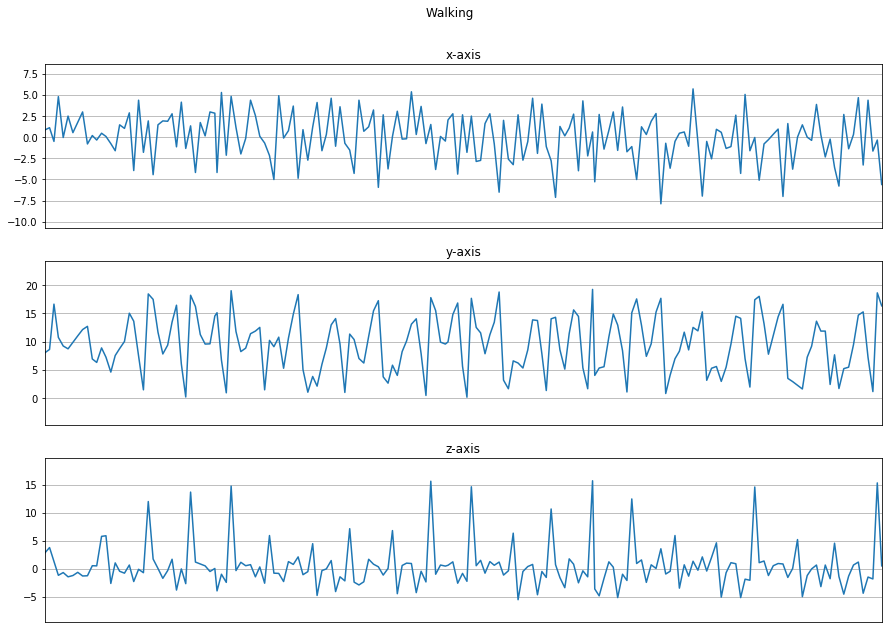

In [6]:
# Explore the data and plot the training examples by activity type.
df['activity'].value_counts().plot(kind='bar',
                                   title='Training Examples by Activity Type')
plt.show()

df['user-id'].value_counts().plot(kind='bar',
                                  title='Training Examples by User')
plt.show()

for activity in np.unique(df["activity"]):
    subset = df[df["activity"] == activity][:180]
    plot_activity(activity, subset)



In [7]:
# Extract the features from time series data
# Split the data into train and test based on user ids

# The number of steps within one time segment
TIME_PERIODS = 80
# The steps to take from one segment to the next; if this value is equal to
# TIME_PERIODS, then there is no overlap between the segments
STEP_DISTANCE = 40

# Differentiate between the test data set and the training data set
df_test = df[df['user-id'] > 28]
df_train = df[df['user-id'] <= 28]

# SAS Deep Learning has the built-in normalization method
# ignore these steps

# Normalize features for training data set
#df_train['x-axis'] = feature_normalize(df['x-axis'])
#df_train['y-axis'] = feature_normalize(df['y-axis'])
#df_train['z-axis'] = feature_normalize(df['z-axis'])
# Round in order to comply to NSNumber from iOS
#df_train = df_train.round({'x-axis': 6, 'y-axis': 6, 'z-axis': 6})

# Reshape the training data into segments
# so that they can be processed by the network
x_train, y_train = create_segments_and_labels(df_train,
                                              TIME_PERIODS,
                                              STEP_DISTANCE,
                                              LABEL)

In [8]:
df_train.head()

,user-id,activity,timestamp,x-axis,y-axis,z-axis,ActivityEncoded
8489,17,Walking,57869902574000,0.572055,9.806650,-0.531194,5
8490,17,Walking,57870012316000,-0.000000,10.188020,-0.572055,5
8491,17,Walking,57870122301000,-0.231546,9.847511,-0.694638,5
8492,17,Walking,57870222246000,0.149824,10.079058,-0.503953,5
8493,17,Walking,57870332292000,0.149824,10.147159,-0.612916,5


In [9]:
df_test.head()

,user-id,activity,timestamp,x-axis,y-axis,z-axis,ActivityEncoded
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953,1
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424,1
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722,1
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717,1
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164,1


In [10]:
x_train.shape

(20868, 80, 3)

In [11]:
y_train.shape

(20868,)

In [12]:
# prepare the test data
x_test, y_test = create_segments_and_labels(df_test,
                                            TIME_PERIODS,
                                            STEP_DISTANCE,
                                            LABEL)

In [13]:
x_test.shape

(6584, 80, 3)

In [14]:
y_test

array([1, 1, 1, ..., 3, 3, 3])

# Convert Numpy Arrays to Data Frames

In [15]:
x_train1 = x_train.reshape(-1, 240)

In [16]:
x_train1.shape

(20868, 240)

In [17]:
x_test1 = x_test.reshape(-1, 240)

In [18]:
x_test1.shape

(6584, 240)

In [19]:
train_data = pd.DataFrame.from_records(x_train1)

train_data['Activity'] = y_train

In [20]:
train_data.head()

,0,1,2,3,4,5,6,7,8,9,...,231,232,233,234,235,236,237,238,239,Activity
0,0.572055,-0.000000,-0.231546,0.149824,0.149824,0.612916,0.108963,-0.108963,-0.081722,0.313268,...,-3.296124,0.313268,-1.988571,-0.231546,-1.797886,-2.410802,-0.231546,0.994285,4.985047,5
1,1.457377,1.539099,2.410802,3.786457,2.560625,1.539099,1.729784,0.844462,0.081722,2.070293,...,-4.140586,-1.076007,-2.833032,-0.653777,0.531194,-4.018003,-0.612916,-1.144109,5.366417,5
2,2.029432,2.410802,-0.803600,2.410802,5.516241,2.982856,1.035146,1.838747,0.762739,2.792171,...,-4.099725,-0.149824,0.190685,-0.340509,-1.797886,-0.912563,-0.231546,2.533385,7.014479,5
3,-0.108963,-1.307553,2.833032,3.486809,4.331271,5.216593,0.463092,3.827318,0.381370,4.753501,...,0.762739,-2.492524,-0.299648,-0.994285,-3.636633,0.422231,-0.503953,3.486809,5.475380,5
4,1.879608,2.764930,1.757025,4.208687,6.851035,0.503953,1.607201,2.029432,1.607201,1.539099,...,-1.334794,-0.340509,0.108963,-1.729784,0.381370,-0.340509,0.531194,5.325556,-2.369941,5


In [21]:
test_data = pd.DataFrame.from_records(x_test1)

test_data['Activity'] = y_test

In [22]:
test_data.head()

,0,1,2,3,4,5,6,7,8,9,...,231,232,233,234,235,236,237,238,239,Activity
0,-0.694638,5.012288,4.903325,-0.612916,-1.184970,1.375655,-0.612916,-0.503953,-8.430995,0.953424,...,6.442424,1.416516,-6.020194,-6.428804,-0.272407,4.440233,1.144109,-2.724070,8.471856,1
1,5.666065,0.231546,-4.821603,1.838747,-3.296124,11.604536,-3.173541,0.612916,-7.886181,3.146300,...,3.255263,0.108963,5.979332,0.190685,11.141444,3.255263,0.762739,8.008764,-0.381370,1
2,0.422231,-3.568531,-4.671779,-2.138395,-1.334794,-2.914754,3.527670,-4.058864,7.586534,-5.175732,...,-2.751310,9.888372,5.407278,4.671779,1.184970,-3.445948,7.436710,-8.921328,-11.032481,1
3,-1.525479,-4.753501,1.797886,-0.803600,-1.225831,-4.630918,1.988571,-4.630918,12.299174,0.994285,...,7.627395,-8.349273,9.575105,2.220117,4.481094,0.081722,-5.856750,7.123442,-9.112013,1
4,-1.729784,-3.214402,-2.301839,-4.794363,4.058864,1.688923,2.260978,2.260978,5.597963,-2.070293,...,-11.536434,-8.812365,4.290410,2.220117,8.349273,5.788648,-9.888372,1.797886,-1.334794,1


# Upload data frames to CAS

In [23]:
conn = CAS('host_name', port_number)

In [24]:
train_tbl = conn.upload_frame(train_data, casout=dict(name='train', replace=True))

NOTE: Cloud Analytic Services made the uploaded file available as table TRAIN in caslib CASUSER(xianhu).
NOTE: The table TRAIN has been created in caslib CASUSER(xianhu) from binary data uploaded to Cloud Analytic Services.


In [25]:
conn.shuffle(train_tbl, casout=dict(name='train', replace=True))

[caslib]

 'CASUSER(xianhu)'

[tableName]

 'TRAIN'

[casTable]

 CASTable('TRAIN', caslib='CASUSER(xianhu)')

+ Elapsed: 0.16s, user: 0.171s, sys: 1.07s, mem: 140mb

In [26]:
test_tbl = conn.upload_frame(test_data, casout=dict(name='test', replace=True))

NOTE: Cloud Analytic Services made the uploaded file available as table TEST in caslib CASUSER(xianhu).
NOTE: The table TEST has been created in caslib CASUSER(xianhu) from binary data uploaded to Cloud Analytic Services.


In [27]:
# check the label distribution
train_tbl.freq(inputs='activity')

,Column,NumVar,FmtVar,Level,Frequency
0,Activity,0.0,0,1,1864.0
1,Activity,1.0,1,2,6567.0
2,Activity,2.0,2,3,1050.0
3,Activity,3.0,3,4,833.0
4,Activity,4.0,4,5,2342.0
5,Activity,5.0,5,6,8212.0


In [28]:
test_tbl.freq(inputs='activity')

,Column,NumVar,FmtVar,Level,Frequency
0,Activity,0.0,0,1,650.0
1,Activity,1.0,1,2,1990.0
2,Activity,2.0,2,3,452.0
3,Activity,3.0,3,4,370.0
4,Activity,4.0,4,5,725.0
5,Activity,5.0,5,6,2397.0


In [29]:
# check some feature summaries
train_tbl.summary(inputs=['100', '210'])

,Column,Min,Max,N,NMiss,Mean,Sum,Std,StdErr,Var,USS,CSS,CV,TValue,ProbT,Skewness,Kurtosis
0,100,-19.610001,20.040001,20868.0,0.0,7.138939,148975.371962,6.747646,0.046710,45.530726,2.013616e+06,950089.661291,94.518895,152.834632,0.000000e+00,-0.578678,0.877895
1,210,-19.799999,19.610001,20868.0,0.0,0.482629,10071.497045,4.831241,0.033444,23.340886,4.919151e+05,487054.270507,1001.026255,14.430951,5.565173e-47,0.286330,1.231190


In [30]:
test_tbl.summary(inputs=['100', '210'])

,Column,Min,Max,N,NMiss,Mean,Sum,Std,StdErr,Var,USS,CSS,CV,TValue,ProbT,Skewness,Kurtosis
0,100,-19.610001,19.760000,6584.0,0.0,7.609204,50098.998436,6.577274,0.081059,43.260530,665997.56373,284784.069763,86.438396,93.872463,0.000000,-0.417273,0.133846
1,210,-19.270000,17.969999,6584.0,0.0,0.190830,1256.424932,4.465925,0.055038,19.944487,131534.32353,131294.559920,2340.263261,3.467210,0.000529,0.117174,0.870988


# Split the training data

Here we show the train-test spliting using the `two_way_split` function in `dlpy.splitting`. It performs random sampling and split the data into `train_data_tbl` and `validation_data_tbl` (on the server side). It is perferred over splitting on the local client side when the data is large, or already hosted on the server. 

In [31]:
train_data_tbl, validation_data_tbl = two_way_split(train_tbl, test_rate=20, seed=1234, stratify=False, im_table=False)

In [32]:
train_data_tbl.numrows()

[numrows]

 16694

+ Elapsed: 0.000365s, user: 0.000327s, mem: 0.498mb

In [33]:
validation_data_tbl.numrows()

[numrows]

 4174

+ Elapsed: 0.000752s, user: 0.000339s, sys: 0.000378s, mem: 0.498mb

# Build the neural network model with 1D convolutions

In [34]:
# the model is built to closely repeat the model from https://github.com/ni79ls/har-keras-cnn
# note SAS deep learning uses automatic padding to maintain the feature map sizes
model_m = Sequential(conn)
# three feature maps: x, y, and z. Each one has 80*1 numbers
model_m.add(InputLayer(width=80, height=1, n_channels=3, std='std'))
model_m.add(Conv1D(100, 10, act='relu', init='msra', include_bias=True))
model_m.add(Conv1D(100, 10, act='relu', init='msra', include_bias=True))
model_m.add(Pooling(stride=3, width=3, height=1))
model_m.add(Conv1D(160, 10, act='relu',  init='msra', include_bias=True))
model_m.add(Conv1D(160, 10, act='relu',  init='msra', include_bias=True))
model_m.add(GlobalAveragePooling1D(dropout=0.5))
model_m.add(OutputLayer(n=6, act='softmax'))

NOTE: Input layer added.
NOTE: 1D Convolution layer added.
NOTE: 1D Convolution layer added.
NOTE: Pooling layer added.
NOTE: 1D Convolution layer added.
NOTE: 1D Convolution layer added.
NOTE: Pooling layer added.
NOTE: Output layer added.
NOTE: Model compiled successfully.


In [35]:
model_m.print_summary()

,Layer Id,Layer,Type,Kernel Size,Stride,Activation,Output Size,Number of Parameters
0,0,Input1,input,,,None,"(1, 80, 3)","(0, 0)"
1,1,Convo.1,convo,"(1, 10)","(1, 1)",Relu,"(1, 80, 100)","(3000, 100)"
2,2,Convo.2,convo,"(1, 10)","(1, 1)",Relu,"(1, 80, 100)","(100000, 100)"
3,3,Pool1,pool,"(1, 3)","(3, 3)",Max,"(1, 27, 100)","(0, 0)"
4,4,Convo.3,convo,"(1, 10)","(1, 1)",Relu,"(1, 27, 160)","(160000, 160)"
5,5,Convo.4,convo,"(1, 10)","(1, 1)",Relu,"(1, 27, 160)","(256000, 160)"
6,6,Pool2,pool,"(1, 27)","(1, 1)",Mean,"(1, 1, 160)","(0, 0)"
7,7,Output1,output,"(160, 6)",,Softmax,6,"(960, 6)"
8,,,,,,,,520486


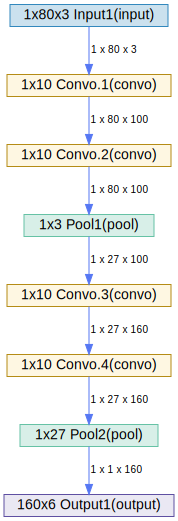

In [36]:
model_m.plot_network()

# Train the neural network

Here we specify the Adam optimizer to show a **scheduled training approach**:

We use `learning_rate_policy='step'` to specify stepwise learning rate decreasing policy. The step size is `step_size=20`, which means every 5 epochs, the `learning_rate` will be multiplied by factor `gamma=0.9`. In addition, we set `log_level=2` to visualize the training log.

In [37]:
# Create the variable list
inputList=[]
for i in range(train_data.columns.shape[0]):
    inputList.append(str(train_data.columns[i]))

In [38]:
#conn.dropTable(model_m.model_weights)

In [39]:
optimizer = Optimizer(algorithm=AdamSolver(learning_rate=0.001, learning_rate_policy='step', 
                                               step_size=30), 
                      mini_batch_size=400, seed=1234, max_epochs=60, log_level=2, reg_l2=0.00001)

model_m.fit(train_data_tbl, valid_table=validation_data_tbl, 
                     n_threads=1,
                     seed=24561,
                     record_seed=12340,
                     inputs=inputList, nominals=['Activity'], 
                     gpu=Gpu(devices=0),
                     force_equal_padding=True,
                     target='Activity', optimizer=optimizer)

NOTE: Training from scratch.
NOTE: Using dlgrd010.unx.sas.com: 1 out of 2 available GPU devices.
NOTE:  Synchronous mode is enabled.
NOTE:  The total number of parameters is 520486.
NOTE:  The approximate memory cost is 10.00 MB.
NOTE:  Loading weights cost       0.00 (s).
NOTE:  Initializing each layer cost       2.12 (s).
NOTE:  The total number of threads on each worker is 1.
NOTE:  The total mini-batch size per thread on each worker is 400.
NOTE:  The maximum mini-batch size across all workers for the synchronous mode is 400.
NOTE:  Target variable: Activity
NOTE:  Number of levels for the target variable:      6
NOTE:  Levels for the target variable:
NOTE:  Level      0:            0
NOTE:  Level      1:            1
NOTE:  Level      2:            2
NOTE:  Level      3:            3
NOTE:  Level      4:            4
NOTE:  Level      5:            5
NOTE:  Number of input variables:   240
NOTE:  Number of numeric input variables:    240
NOTE:  Epoch Learning Rate        Loss  Fit

,Descr,Value
0,Model Name,model_9l2hau
1,Model Type,Convolutional Neural Network
2,Number of Layers,8
3,Number of Input Layers,1
4,Number of Output Layers,1
5,Number of Convolutional Layers,4
6,Number of Pooling Layers,2
7,Number of Fully Connected Layers,0
8,Number of Weight Parameters,519960
9,Number of Bias Parameters,526


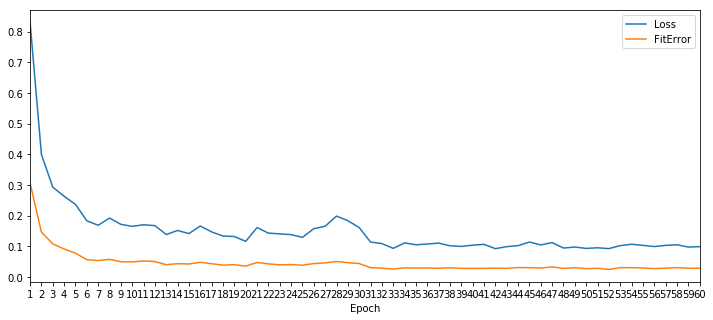

In [40]:
# Plot the training history.
model_m.plot_training_history()

# Evaluate testing results with various classification metrics

Note: for example simplicity, we just evaluate the testing results. Feel free to check the training result by changing `test_tbl` to `train_tbl`.

In [41]:
# You might observe small variations from the model accuracies shown 
# in the example results. These small differences are due to the 
# randomn shuffling of the data that occurred when the table partitions
# 'train_data_tbl' and 'validation_data_tbl' were created.
model_m.predict(test_tbl)

[ScoreInfo]

                          Descr         Value
 0  Number of Observations Read          6584
 1  Number of Observations Used          6584
 2  Misclassification Error (%)      9.477521
 3                   Loss Error      0.526594

[OutputCasTables]

             casLib              Name  Rows  Columns  \
 0  CASUSER(xianhu)  Valid_Res_mYgD3S  6584      250   
 
                                             casTable  
 0  CASTable('Valid_Res_mYgD3S', caslib='CASUSER(x...  

+ Elapsed: 0.301s, user: 9.32s, sys: 0.527s, mem: 289mb

In [42]:
test_result_table = model_m.valid_res_tbl

In [43]:
# Show the confusion matrix
display(confusion_matrix(test_result_table['Activity'], test_result_table['I_Activity']))

,0,1,2,3,4,5
Activity,,,,,,
0.0,410.0,20.0,0.0,0.0,123.0,97.0
1.0,25.0,1889.0,0.0,0.0,38.0,38.0
2.0,0.0,0.0,410.0,0.0,42.0,0.0
3.0,0.0,0.0,31.0,332.0,7.0,0.0
4.0,102.0,9.0,0.0,7.0,581.0,26.0
5.0,20.0,24.0,0.0,0.0,15.0,2338.0


In [44]:
# Calculate the accuracy score
acc_score = accuracy_score(test_result_table['Activity'], test_result_table['I_Activity'])
print('the accuracy score is {:.6f}'.format(acc_score))

the accuracy score is 0.905225


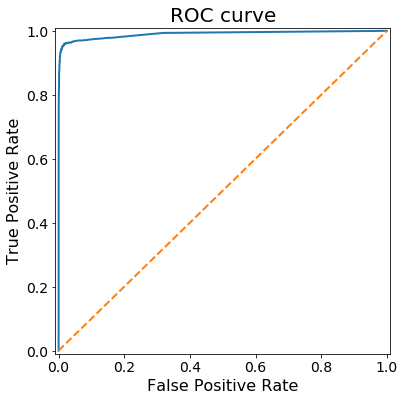

In [45]:
# Plot the ROC curve for target_class = 1
plot_roc(test_result_table['Activity'], test_result_table['P_Activity1'], pos_label=1, figsize=(6,6), linewidth=2)

In [46]:
# Calculate the area under the ROC curve.
auc_of_roc = roc_auc_score(test_result_table['Activity'], test_result_table['P_Activity1'], pos_label=1)
print('the area under the ROC curve is {:.6f}'.format(auc_of_roc))

the area under the ROC curve is 0.990058


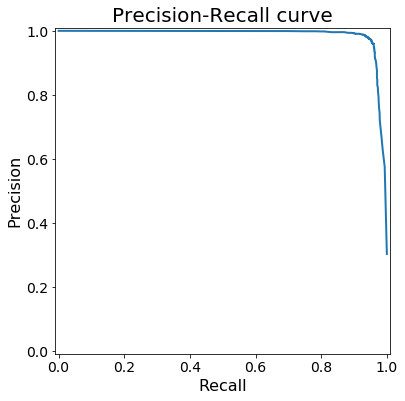

In [47]:
# Plot the precision recall curve for target_class = 1
plot_precision_recall(test_result_table['Activity'], test_result_table['P_Activity1'], pos_label=1, figsize=(6,6), 
                      linewidth=2)

In [48]:
# Calculate the average precision score for target_class = 1
ap = average_precision_score(test_result_table['Activity'], test_result_table['P_Activity1'], pos_label=1)
print('the average precision score is {:.6f}'.format(ap))

the average precision score is 0.985025


In [49]:
# Calculate the f1 score for target_class 1
f1sc = f1_score(test_result_table['Activity'], test_result_table['I_Activity'], pos_label=1)
print('the f1 score is {:.6f}'.format(f1sc))

the f1 score is 0.960834


In [50]:
conn.endsession()

+ Elapsed: 0.000251s, sys: 0.000225s, mem: 0.203mb